In [1]:
import logging
logging.basicConfig(filename = '../logging/BrainNetsLog.log', 
                    filemode='w', 
                    format = '%(asctime)s %(name)s %(lineno)d %(funcName)s %(levelname)s:%(message)s', 
                    level = logging.DEBUG)
logger = logging.getLogger('Jupyter Notebook')

In [2]:
import BrainNets as bn
reload(bn)
import dataOperator as do
reload(do)

import time
import theano
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

%matplotlib inline 

/home/mountain/anaconda3/envs/biomediclasagne/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda0: GeForce GTX 750 Ti (0000:01:00.0)


In [3]:
synthsisTrain = do.cubesGetor(cubeDirectory = '../data/tryGenerateCubeData/', batchSize = 1000)
synthsisVal = do.cubesGetor(cubeDirectory = '../data/tryGenerateCubeData/', trainOrVal = 'val', batchSize = 1000)

In [4]:
net = bn.Network()
trainFunc = net.trainFunction()
valAndTestFunc = net.valAndTestFunction()

In [3]:
trainCubes = do.cubesGetor(cubeDirectory = '../data/tryGenerateCubeData/')
valCubes = do.cubesGetor(cubeDirectory = '../data/tryGenerateCubeData/', trainOrVal = 'val')

In [3]:
trainCubes = do.cubesGetor(cubeDirectory = '../data/tryGenerateCubeData/', 
                           sourceDataDirectory = '../data/SimpleExploreSomeData/', 
                           onTheFly = True)
valCubes = do.cubesGetor(cubeDirectory = '../data/tryGenerateCubeData/', 
                         sourceDataDirectory = '../data/SimpleExploreSomeData/',
                         onTheFly = True, 
                         trainOrVal = 'val')

In [7]:
for inputs, targets in trainCubes.fetchCubes(batchSize = 10):
    print inputs.shape, targets

(10, 1, 5, 5, 5) [0 0 2 0 0 2 0 0 0 2]
(10, 1, 5, 5, 5) [2 0 0 2 0 0 0 2 0 0]
(10, 1, 5, 5, 5) [0 0 2 0 2 2 2 2 0 2]
(10, 1, 5, 5, 5) [2 0 2 2 2 2 0 0 0 2]
(10, 1, 5, 5, 5) [2 0 2 2 0 0 2 0 2 0]
(10, 1, 5, 5, 5) [2 2 2 0 2 2 2 2 2 0]
(10, 1, 5, 5, 5) [0 0 0 0 0 0 2 0 0 0]
(10, 1, 5, 5, 5) [2 2 0 2 0 0 0 0 0 0]
(10, 1, 5, 5, 5) [0 2 0 0 0 0 0 0 2 2]
(10, 1, 5, 5, 5) [2 0 0 2 0 2 2 0 2 0]
(10, 1, 5, 5, 5) [2 0 2 0 0 2 0 0 0 2]
(10, 1, 5, 5, 5) [2 0 2 0 0 0 2 2 0 0]
(10, 1, 5, 5, 5) [2 2 2 2 0 2 2 2 2 2]
(10, 1, 5, 5, 5) [2 2 0 2 2 0 2 0 2 0]
(10, 1, 5, 5, 5) [2 0 2 2 2 0 0 0 0 0]
(10, 1, 5, 5, 5) [2 2 0 2 0 0 2 2 2 2]
(10, 1, 5, 5, 5) [2 0 0 0 2 0 0 0 2 2]
(10, 1, 5, 5, 5) [2 2 2 2 0 2 2 2 2 2]
(10, 1, 5, 5, 5) [0 0 2 2 0 2 0 0 0 2]
(10, 1, 5, 5, 5) [2 2 0 0 2 0 2 0 2 2]
(10, 1, 5, 5, 5) [0 0 0 0 0 2 0 0 2 2]
(10, 1, 5, 5, 5) [0 0 0 0 0 0 2 0 2 2]
(10, 1, 5, 5, 5) [0 2 0 0 0 0 0 2 2 2]
(10, 1, 5, 5, 5) [2 0 0 2 2 0 2 2 0 2]
(10, 1, 5, 5, 5) [2 0 2 0 2 0 2 0 2 2]
(10, 1, 5, 5, 5) [2 0 2 2

KeyboardInterrupt: 

In [6]:
numEpochs = 100

In [7]:
trainingLoss = []
validationLoss = []
validationACC = []

In [8]:
for epoch in range(numEpochs):
    logger.info('{} th of {} epochs'.format(epoch, numEpochs))
    
    trainError = 0
    startTime = time.time()
    trainBatch = 0
    
    for batch in synthsisTrain.generateSynthesisData(1000, group0 = (0,5), group1 = (1, 5)):
        inputs, targets = batch
        target, trainPre, trainAcc, trainLoc, trainErr, trainPairLoss = trainFunc(inputs, targets)
        
        npTarget = np.array(target)
        npPre = np.array(trainLoc)
        rightOrWrong = npTarget != npPre
        
#         print rightOrWrong
        wrong = npTarget[rightOrWrong]

        trainError += trainErr
        trainBatch += 1
#         logger.debug('The target equals {}'.format(target))
#         logger.debug('The prediction equals {}'.format(trainPre))
        logger.debug('The location equals {} '.format(trainLoc))
#         logger.debug('The train ACC equals {} '.format(trainAcc))
#         logger.debug('The pair loss equals {} '.format(trainPairLoss))
#         logger.debug('The zeroloss equals {} '.format(zeroLoss))
        logger.debug('The wrong predict points equals {} '.format(wrong.size))
    valError = 0
    valACC = 0
    valBatches = 0
        
    for batch in synthsisVal.generateSynthesisData(1000, group0 = (1,5), group1 = (1, 5)):
        inputs, targets = batch
        targets = targets
        Err, ACC, location, targetVar = valAndTestFunc(inputs, targets)
        valError += Err
        valACC += ACC
        valBatches += 1
        
#         logger.debug('The location equals {} and the target_var equals {}'.format(location, targetVar))

    # Then we print the results for this epoch:
    print "Epoch {} of {} took {:.3f}s".format(epoch + 1, numEpochs, time.time() - startTime)
    print "  training loss:\t\t{:.6f}".format(trainError / trainBatch)
    print "  validation loss:\t\t{:.6f}".format(valError / valBatches)
    print "  validation accuracy:\t\t{:.2f} %".format(valACC / valBatches * 100)
    
    trainingLoss.append(trainError / trainBatch)
    validationLoss.append(valError / valBatches)
    validationACC.append(valACC / valBatches * 100)

Epoch 1 of 100 took 1.999s
  training loss:		0.783556
  validation loss:		0.693157
  validation accuracy:		49.98 %
Epoch 2 of 100 took 1.969s
  training loss:		0.693057
  validation loss:		0.693163
  validation accuracy:		50.41 %
Epoch 3 of 100 took 1.960s
  training loss:		0.693106
  validation loss:		0.693195
  validation accuracy:		50.25 %
Epoch 4 of 100 took 1.938s
  training loss:		0.692975
  validation loss:		0.693147
  validation accuracy:		50.18 %
Epoch 5 of 100 took 1.903s
  training loss:		0.692902
  validation loss:		0.693264
  validation accuracy:		49.78 %
Epoch 6 of 100 took 1.939s
  training loss:		0.692902
  validation loss:		0.693209
  validation accuracy:		49.90 %
Epoch 7 of 100 took 1.974s
  training loss:		0.692864
  validation loss:		0.693317
  validation accuracy:		50.35 %
Epoch 8 of 100 took 1.950s
  training loss:		0.692762
  validation loss:		0.693214
  validation accuracy:		50.09 %
Epoch 9 of 100 took 1.982s
  training loss:		0.692719
  validation loss:		0.6933

KeyboardInterrupt: 

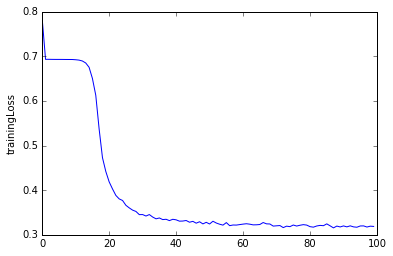

In [9]:
plt.plot(trainingLoss)
plt.ylabel('trainingLoss')
plt.show()

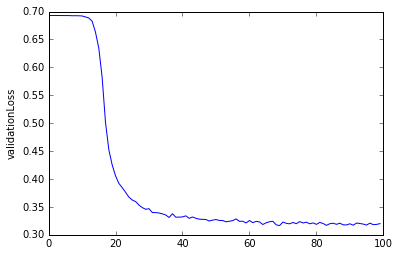

In [10]:
plt.plot(validationLoss)
plt.ylabel('validationLoss')
plt.show()

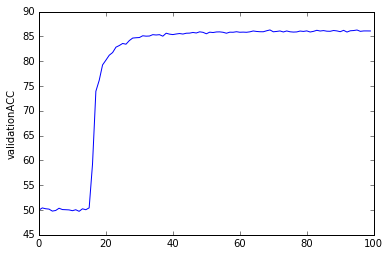

In [11]:
plt.plot(validationACC)
plt.ylabel('validationACC')
plt.show()

In [4]:
theano.printing.debugprint(trainFunc)

HostFromGpu(gpuarray) [id A] 'mean'   136
 |GpuElemwise{TrueDiv}[(0, 0)]<gpuarray> [id B] ''   134
   |GpuCAReduceCuda{add} [id C] ''   133
   | |GpuCrossentropySoftmaxArgmax1HotWithBias.0 [id D] ''   132
   |   |GpuReshape{2} [id E] ''   129
   |   | |GpuElemwise{Composite{(i0 * (i1 + Abs(i1)))}}[]<gpuarray> [id F] ''   128
   |   | | |GpuArrayConstant{[[[[[ 0.5]]]]]} [id G]
   |   | | |InplaceGpuDimShuffle{0,2,3,4,1} [id H] ''   127
   |   | |   |GpuElemwise{Add}[(0, 0)]<gpuarray> [id I] ''   126
   |   | |     |GpuDnnConv{algo='none', inplace=True} [id J] ''   125
   |   | |     | |GpuContiguous [id K] ''   106
   |   | |     | | |GpuElemwise{Composite{(i0 * (i1 + Abs(i1)))}}[]<gpuarray> [id L] ''   105
   |   | |     | |   |GpuArrayConstant{[[[[[ 0.5]]]]]} [id G]
   |   | |     | |   |GpuElemwise{Add}[(0, 0)]<gpuarray> [id M] ''   104
   |   | |     | |     |GpuDnnConv{algo='none', inplace=True} [id N] ''   103
   |   | |     | |     | |GpuContiguous [id O] ''   84
   |   | |     |

In [1]:
33*33*33

35937

In [4]:
noNorm = '/home/mountain/Desktop/BrainNets/data/BRATS2015_Training/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/VSD.Brain.XX.O.MR_Flair.54512.mha'
norm = '/home/mountain/Desktop/BrainNets/data/normalizedDataSet/HGG/brats_2013_pat0001_1/VSD.Brain.XX.O.MR_Flair.54512/VSD.Brain.XX.O.MR_Flair.54512.mha'

In [6]:
noNormImage = sitk.ReadImage(noNorm)
normImage = sitk.ReadImage(norm)

In [7]:
noNormA = sitk.GetArrayFromImage(noNormImage)
normA = sitk.GetArrayFromImage(normImage)

In [3]:
do.normalizeDataSet(dataPath = '../data/BRATS2015_Training/', 
                    normalizedDataDir = '../data/normalizedDataSet/')

In [3]:
do.makeCubesOnTheFly(dataPath = '../data/SimpleExploreSomeData/', 
             cubeDirectory = '../data/tryGenerateCubeData/',
             cubeSize = 5)